# Low $\frac{\chi}{\kappa}$ regime Ramsey Measurement-Induced Dephasing Exp

In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_94452/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Overall Job Composition

1. Meas G, E
2. Ramsey Meas Exp with $\tau_R$ varying from 0 to 200ns (looking for $\kappa$ effects)
3. Ramsey Meas Exp with $\tau_R$ varying from 200ns to 200ns + $\frac{n}{\Delta}$ to measure n periods of Ramsey Oscillation

1217.857142857143
112


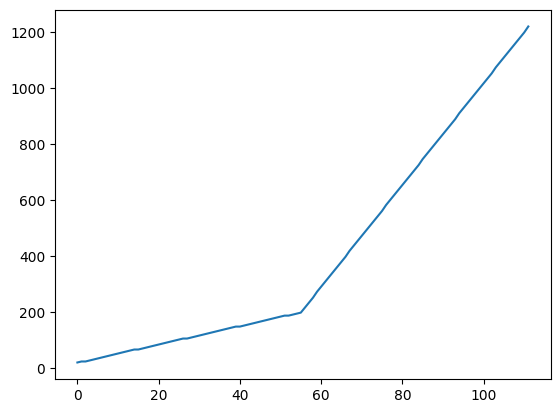

In [4]:
from utils import get_dt_from, convert_arr_to_dt, acquisition_checker

meas_tau_1_dt = 2 * measure_pulse.duration
buffer_dt = measure_delay.duration
delta_freq = 5 * MHz
num_periods = 5
ramsey_meas_1_amp = measure_pulse.amp
ramsey_amps_linspace = np.array([0.1, 0.2, 0.3, ramsey_meas_1_amp, 0.6])

# Short Timescale Linspace
num_short = 56
short_low = 20 * ns
short_high = 200 * ns
short_ramsey_linspace = np.linspace(short_low, short_high, num_short)
short_ramsey_linspace = convert_arr_to_dt(short_ramsey_linspace)

# Long Timescale Linspace
num_long = 56
long_low = short_high + num_periods / (delta_freq * num_long)
long_high = long_low + num_periods / delta_freq
long_ramsey_linspace = np.linspace(long_low, long_high, num_long)
long_ramsey_linspace = convert_arr_to_dt(long_ramsey_linspace)

print(long_high/ns)

ramsey_total_linspace = np.concatenate((short_ramsey_linspace, long_ramsey_linspace))
print(len(ramsey_total_linspace))
plt.plot(ramsey_total_linspace/ns)

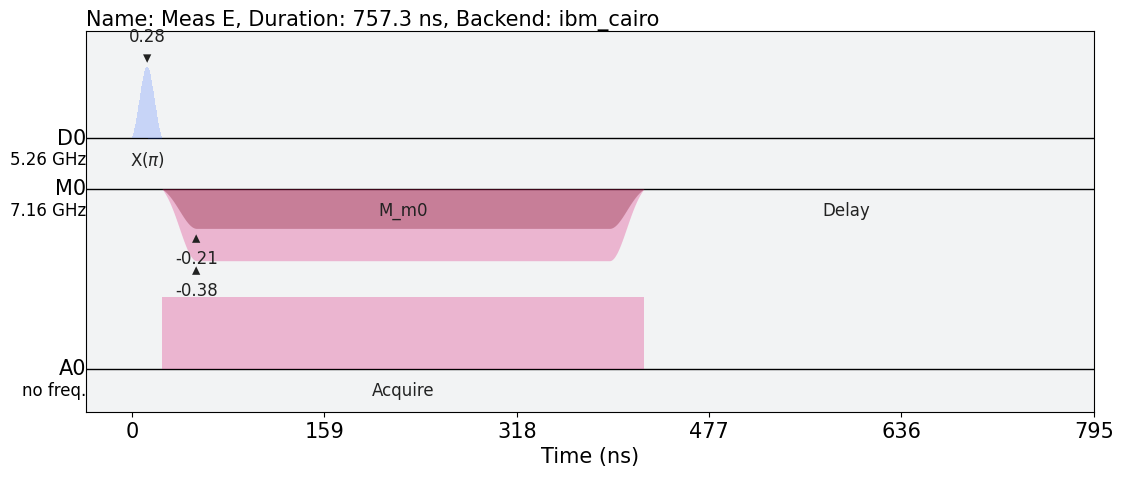

In [5]:
## Meas G/E Experiments

meas_ge_exp = []

with pulse.build(
    backend=backend, 
    default_alignment='sequential', 
    name='Meas G') as meas_g_sched:
    pulse.measure(qubit, pulse.MemorySlot(qubit))

meas_ge_exp.append(meas_g_sched)

with pulse.build(
    backend=backend, 
    default_alignment='sequential', 
    name='Meas E') as meas_e_sched:
    qubit_chan = pulse.drive_channel(qubit)

    pulse.play(x_pulse, qubit_chan)
    pulse.measure(qubit, pulse.MemorySlot(qubit))

meas_ge_exp.append(meas_e_sched)

meas_ge_exp[1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

560


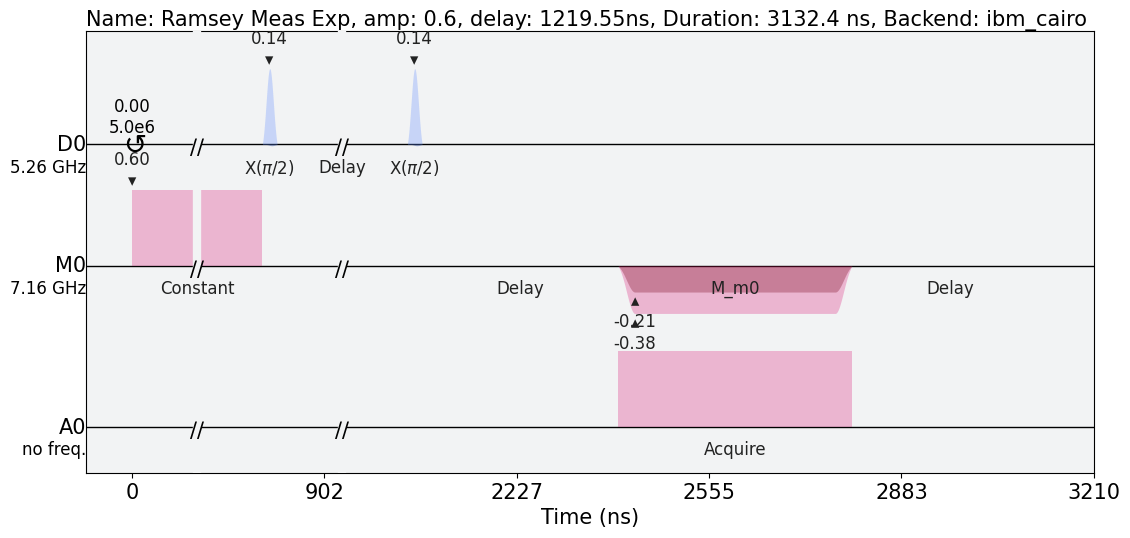

In [6]:
## Ramsey Experiments

ramsey_meas_exps = []

for r_amp in ramsey_amps_linspace:
    ramsey_meas_1_pulse = pulse.Constant(meas_tau_1_dt, r_amp)

    for tR_delay in ramsey_total_linspace:
        tR_delay_dt = get_dt_from(tR_delay)

        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Ramsey Meas Exp, amp: {int(1e3*r_amp)/1e3}, delay: {int(1e2*tR_delay_dt*dt/ns)/1e2}ns'
        ) as ramsey_meas_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(delta_freq, qubit_chan)
            
            pulse.play(ramsey_meas_1_pulse, meas_chan)
            pulse.play(sx_pulse, qubit_chan)
            pulse.delay(tR_delay_dt, qubit_chan)
            pulse.play(sx_pulse, qubit_chan)
            pulse.delay(buffer_dt, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        ramsey_meas_exps.append(ramsey_meas_sched)

print(len(ramsey_meas_exps))

ramsey_meas_exps[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

562
281


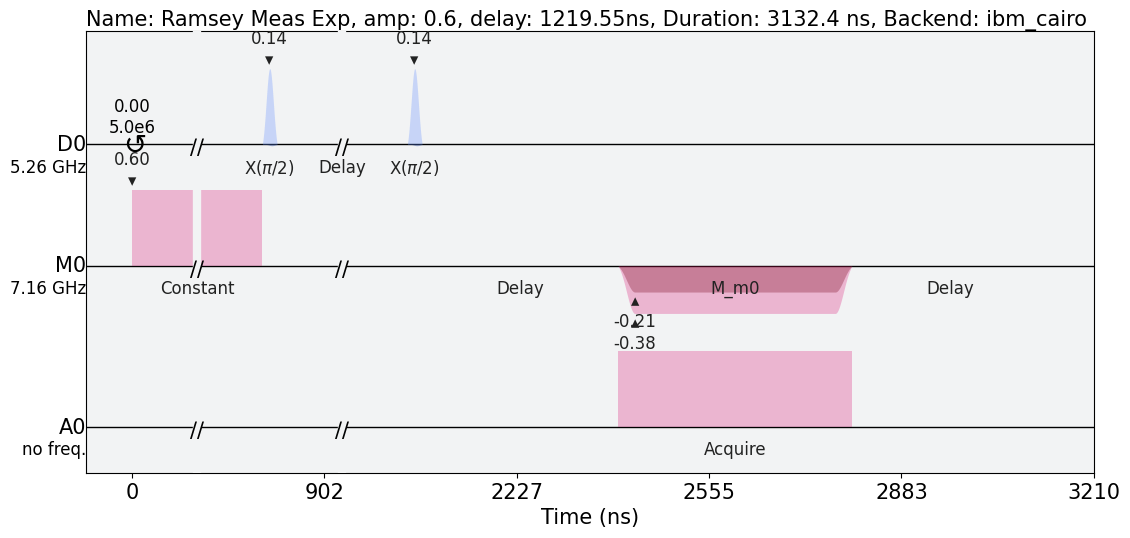

In [7]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

total_exp = meas_ge_exp + ramsey_meas_exps
acquisition_checker(total_exp)
print(len(total_exp))

job_1, job_2 = np.array(total_exp).reshape(2, -1).tolist()

print(len(job_1))

total_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [9]:
# Running job_1, job_2

job_experiment = backend.run(job_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [8]:
job_1 = provider.backend.retrieve_job('cq1xwqjdhsd0008ea3j0')
job_2 = provider.backend.retrieve_job('cq1xwsv7z1hg0086zjk0')

In [9]:
from utils import get_results_arr

result_1 = get_results_arr(job_1.result(), qubit)
result_2 = get_results_arr(job_2.result(), qubit)

In [10]:
big_results = np.concatenate((result_1, result_2), axis=0)
ge_res = big_results[:2]
ramsey_res = big_results[2:]

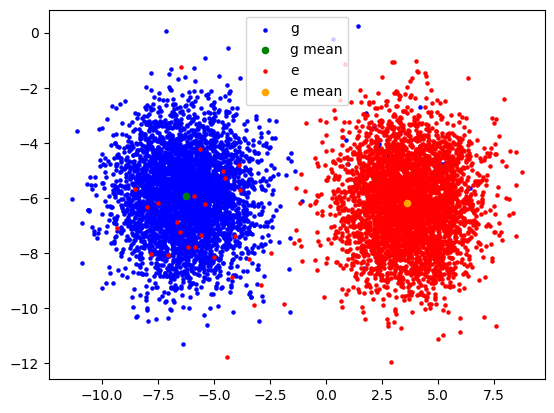

In [11]:
g_res, e_res = ge_res
g_mean, e_mean = np.mean(ge_res, axis=-1)

plt.scatter(g_res.real, g_res.imag, label='g', s=5, color='blue')
plt.scatter(g_mean.real, g_mean.imag, label='g mean', s=20, color='green')
plt.scatter(e_res.real, e_res.imag, label='e', s=5, color='red')
plt.scatter(e_mean.real, e_mean.imag, label='e mean', s=20, color='orange')
plt.legend()
plt.show()

In [12]:
## Classifying Ramsey Results

from utils import get_fidelity, classify_results

prob_0_arr, prob_1_arr = classify_results(ramsey_res, g_mean, e_mean)

In [13]:
big_0_arr = prob_0_arr.reshape(5, -1)
big_1_arr = prob_1_arr.reshape(5, -1)

real_ramsey_res = np.mean(ramsey_res.real, axis=-1).reshape(5, -1)

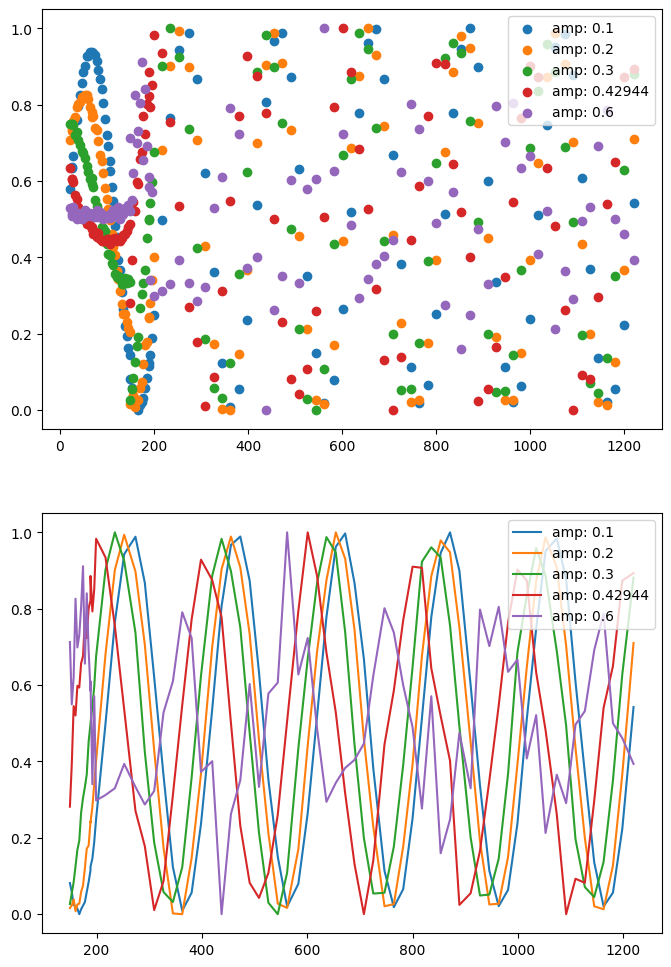

In [24]:
fig, ax = plt.subplots(2, figsize=(8.0, 12.0))

ss_ind = 40
ramsey_ss_linspace = ramsey_total_linspace[ss_ind:]

for ind, plot_arr in enumerate(big_0_arr):
    ss_arr = plot_arr[ss_ind:]
    ss_arr -= np.min(ss_arr)
    ss_arr /= np.max(ss_arr)
    ax[0].scatter(ramsey_total_linspace/ns, plot_arr, label=f'amp: {ramsey_amps_linspace[ind]}')
    ax[1].plot(ramsey_ss_linspace/ns, ss_arr, label=f'amp: {ramsey_amps_linspace[ind]}')
# plt.scatter(ramsey_total_linspace/ns, big_1_arr[0])
ax[0].legend()
ax[1].legend()
plt.show()

## Fitting the Ramsey Results

In [25]:
# Defining the Functions

chi = 0.65 * 2 * np.pi
delta = delta_freq / MHz * 2 * np.pi
gamma_2 = 1/93.94 # From IBMQ Backend Charecterisation

def tau_R(tR, kappa, chi):
    res = (
        kappa * (1. - np.exp(-kappa * tR) * np.cos(chi * tR))
        + chi * np.exp(-kappa * tR) * np.sin(chi * tR)
    )
    res /= (kappa ** 2 + chi ** 2)
    return res

def tau_I(tR, kappa, chi):
    res = (
        -chi * (1. - np.exp(-kappa * tR) * np.cos(chi * tR))
        + kappa * np.exp(-kappa * tR) * np.sin(chi * tR)
    )
    res /= (kappa ** 2 + chi ** 2)
    return res

def ramsey_trace_func(tR, n0, kappa, phi_0):
    tau_R_val = tau_R(tR, kappa, chi)
    tau_I_val = tau_I(tR, kappa, chi)
    trace_res = (
        0.5
        + 0.5 
        * np.exp(-gamma_2 * tR + n0 * chi * tau_I_val)
        * np.sin(delta * tR + n0 * chi * tau_R_val - phi_0)
    )
    return trace_res

In [30]:
exp_ind = 0

x_data = ramsey_total_linspace/us
y_data = big_0_arr[exp_ind]

init_params = [20.0, 20.0, 0.]

params, cov = curve_fit(ramsey_trace_func, x_data, y_data, init_params, maxfev=5000)

print(params)

[1248.95439472  689.19369066    1.65653525]


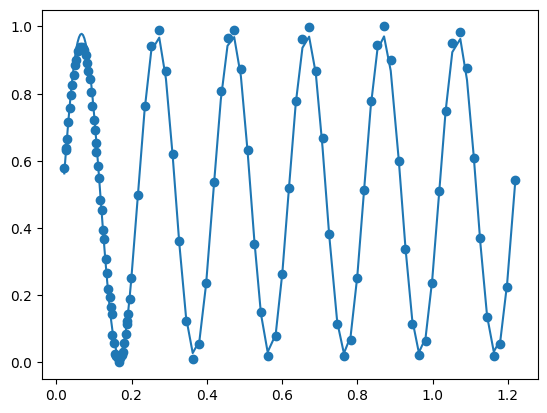

In [31]:
plt.plot(x_data, ramsey_trace_func(x_data, *params))
plt.scatter(x_data, y_data)
plt.show()